# Description

CLIP(Contrastive Language Image Pre-training) Based Model.
We used CLIP to extract features from both images and questions, then combined these features with positional information to train our model. We developed a VQA model based on CLIP, integrating position encoding, cross-attention, and a dynamic gating mechanism. This model achieved a satisfactory accuracy on our benchmark dataset.


# Dataset

For this project, we use two dataset, Vizwiz and VQA datasets. We selected the VQA and VizWiz datasets for their complementary strengths. The VQA dataset provides a broad range of everyday scenes and diverse question types, serving as a strong benchmark for general tasks. The VizWiz dataset features real-world, noisy images from visually impaired users, testing the model’s robustness. This combination improves generalization by exposing the model to both standard and challenging scenarios, aligning well with our goal of building a versatile and reliable VQA system.
### VizWiz
The VizWiz-VQA dataset is derived from real-world photos taken by visually impaired people using a mobile phone app. When taking a photo, the visually impaired person usually asks a question about the picture in order to obtain information about their surroundings.
It is a large-scale visual question answering dataset that contains
- 23954 training image/question pairs
- 205,230 training answer/answer confidence pairs
- 7750 validation image/question pairs
- 43,190 validation answer/answer confidence pairs
- 8,000 test image/question pairs
### VQA Dataset
The VQA dataset is a collection of open-ended questions about images. For our project, we selected the Val2014 subset as the primary dataset. We then split it into 70% for training, 20% for validation, and 10% for testing.
- 214,354 Total Samples
- 70% for training
- 20% for validation
- 10% for testing

# Environment Initial

In this project, due to the extensive computational requirements, our local machine could not support the data processing and model training. Therefore, we utilized Google Colab for these tasks. When using Colab, we needed to set up the environment and configure the file paths in advance to ensure the code runs smoothly.

In [1]:
#check if in local or colab
#if in colab run following two cells
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install levenshtein
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hsqa67qj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hsqa67qj
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=4036d47b6cac3fba864384b0a38fd1196e2159a51c9c1f05f2a38fd2fd50f8b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-nvgz6aia/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


# Import Libraries

In [3]:
# Importing os, numpy and pandas for data manipulation
import os
import numpy as np
import pandas as pd

# For data visualization, we will use matplotlib, wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For saving and loading the preprocessed data, we will use pickle
import pickle

# For Building the model, we will use PyTorch and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader

# For taking the image from the URL, we will use requests
import requests

# For evaluation, we will need sklearn.metrics.average_precision_score
from sklearn.metrics import average_precision_score

# Importing json for results formatting which will be uploaded for evaluation
import json
import random
import math
print('import done')

import done


# Path Configure

In [4]:
#this is path for clip based model training on Vizwiz Dataset
INPUT_PATH = '/content/drive/MyDrive/9444clip/comp9444'
ANNOTATIONS = INPUT_PATH + '/Annotations/Annotations'
TRAIN_PATH = INPUT_PATH + '/train/train'
VALIDATION_PATH = INPUT_PATH + '/val/val'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
OUTPUT_PATH = '/content/drive/MyDrive/9444clip/OUTPUT/'
ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
MODEL_NAME = "ViT-L/14@336px" # This is the backbone of the CLIP model

# Using accelerated computing if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


# Function Define

The following cell defines functions for exploratory data analysis and preprocessing of data
- `read_dataframe` function reads a JSON file and returns a dataframe with required columns
- `split_train_valid_test` function splits the dataframe into train, validation and test sets
- `split_train_test` function splits the dataframe into train and test sets
- `plot_histogram`, `plot_pie`, and `plot_wordcloud` functions plot the histogram, pie chart, and wordcloud of the given column, respectively
- `explore_dataframe` function explores the dataframe by utilizing the previous functions
- `get_number_of_distinct_answers` function returns the number of distinct answers in the dataframe
- `process_images` function processes the images in the dataframe and returns the image features using Open AI's CLIP model
- `process_questions` function processes the questions in the dataframe and returns the question features using Open AI's CLIP model
- `process_single_image` function processes the single image in the dataframe and returns the image features using Open AI's CLIP model
- `process_single_question` function processes the single question in the dataframe and returns the question features using Open AI's CLIP model

In [30]:
def read_dataframe(path):
    """
    Reads the JSON file and returns a dataframe with the required columns (image, question, answers, answer_type, answerable)

    Parameters:
        path (str): Path to the JSON file

    Returns:
        df (pandas.DataFrame): Dataframe with the required columns
    """
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]
    return df
def split_train_valid_test(dataframe, train_size=0.7, valid_size=0.2, test_size=0.1):
    # Step 1: Split into train and remaining sets (remaining will be split into valid and test sets)
    train, remaining = train_test_split(dataframe, test_size=(1 - train_size), random_state=42, stratify=dataframe[['answer_type']])
    # Step 2: Split remaining set into validation and test sets (valid_size is 2/3 of remaining, test_size is 1/3)
    valid, test = train_test_split(remaining, test_size=test_size/(test_size + valid_size), random_state=42, stratify=remaining[['answer_type']])
    return train, valid, test
def split_train_test(dataframe, test_size = 0.05):
    """
    Splits the dataframe into train and test sets

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be split

    Returns:
        train (pandas.DataFrame): Train set
        test (pandas.DataFrame): Test set
    """
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test

def plot_histogram(dataframe, column):
    """
    Plots the histogram of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    """
    Plots the pie chart of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):
    """
    Plots the wordcloud of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

def explore_dataframe(dataframe):
    """
    Explores the dataframe (EDA) by plotting the pie charts, histograms and wordclouds of the columns

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        None
    """
    plot_pie(dataframe, 'answer_type')
    plot_pie(dataframe, 'answerable')
    plot_histogram(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')

def get_number_of_distinct_answers(dataframe):
    """
    Returns the number of distinct answers in the dataframe

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        len(unique_answers_set) (int): Number of distinct answers in the dataframe
    """
    unique_answers_set = set()
    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

def process_images(dataframe, image_path, clip_model, preprocessor, device):
    """
    Processes the images in the dataframe and returns the image features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the images
        image_path (str): Path to the input images
        clip_model (clip.model.CLIP): CLIP model
        preprocessor (clip.model.Preprocess): Preprocessor for the CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        images (list): List of image features
    """
    images = []
    for _, row in dataframe.iterrows():
        full_path = image_path + "/" + row['image']
        image = Image.open(full_path)
        image = preprocessor(image).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)
        images.append(image_features)
    return images

def process_questions(dataframe, clip_model,device):
    """
    Processes the questions in the dataframe and returns the question features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the questions
        clip_model (clip.model.CLIP): CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        questions (list): List of question features
    """
    questions = []
    for _, row in dataframe.iterrows():
        question = row['question']
        question =  clip.tokenize(question).to(device)
        text_features = clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)
        questions.append(text_features)
    return questions

In [ ]:
def process_single_image(image_path, clip_model, preprocessor, device):
    """
    Processes a single image and returns the image feature

    Parameters:
        image_path (str): Path to the image
        clip_model (clip.model.CLIP): CLIP model
        preprocessor (clip.model.Preprocess): Preprocessor for the CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        image_feature (torch.Tensor): Image feature extracted by CLIP
    """
    image = Image.open(image_path).convert("RGB")
    image = preprocessor(image).unsqueeze(0).to(device)
    #with torch.no_grad():
    image_feature = clip_model.encode_image(image).float()
    #image_feature =  image_feature.unsqueeze(0).to(device)
    return torch.flatten(image_feature, start_dim=1)


def process_single_question(question_text, clip_model, device):
    """
    Processes a single question and returns the question feature

    Parameters:
        question_text (str): The question text
        clip_model (clip.model.CLIP): CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        question_feature (torch.Tensor): Question feature extracted by CLIP
    """
    question = clip.tokenize(question_text).to(device)
    #with torch.no_grad():
    question_feature = clip_model.encode_text(question).float()
    return torch.flatten(question_feature, start_dim=1)

# Dataset Define

In [6]:
class VizWizDataset(Dataset):
    def __init__(self, dataframe, answer_type_onehotencoder = None, answer_onehotencoder = None, model_name = "RN50x64", images_features = torch.tensor([]), questions_features = torch.tensor([])):
        super(VizWizDataset, self).__init__()

        # Total counter for all answers before filtering, used in Tie Breaking when building the answer vocabulary
        self.answer_counter = Counter()

        # Saving image & question embeddings
        self.images_features = images_features
        self.questions_features = questions_features
        self.answerable = dataframe['answerable'].to_numpy()

        # Saving the dataframe
        self.dataframe = dataframe

        # List for answers for each question (each question has 10 answers)
        self.answer_counter_per_question = []

        # Populating the counter for words in answers which will be used when building answer vocabulary
        self.build_answer_counter()

        # Building the answer vocabulary according to the methodology explained in the paper
        self.build_answer_vocab()

        # The number of vocabulary words after filtering
        print("Number of distinct answers: ", len(self.get_answer_vocab()))

        # One hot encoding the answers
        if answer_type_onehotencoder is None:
            answer_type_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_type_onehotencoder.fit(self.copied_dataframe[['answer_type']])

        # One hot encoding the answer types
        if answer_onehotencoder is None:
            answer_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_onehotencoder.fit(self.copied_dataframe[['answer']])

        # Saving the one hot encoders
        self.answer_onehotencoder = answer_onehotencoder
        self.answer_type_onehotencoder = answer_type_onehotencoder

        # Transforming the answers and answer types to one hot encoded vectors
        self.answer_onehotencoded = answer_onehotencoder.transform(self.copied_dataframe[['answer']]).toarray()
        self.answer_type_onehotencoded = answer_type_onehotencoder.transform(self.copied_dataframe[['answer_type']]).toarray()

        # Saving the answer categories (vocabulary) which will be used when getting index of the predicted answer
        self.answers_categories = self.answer_onehotencoder.categories_[0].tolist()

        # Saving answers for each question (each question has 10 answers)
        self.build_answer_counter_per_question()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        answer = torch.tensor(self.answer_onehotencoded[index], dtype=torch.float32)
        answer_type = torch.tensor(self.answer_type_onehotencoded[index], dtype=torch.float32)
        answer_counter = torch.tensor(self.answer_counter_per_question[index], dtype=torch.long)
        answerable = torch.tensor(self.answerable[index], dtype=torch.float32)
        return self.images_features[index], self.questions_features[index], answer, answer_type, answer_counter, answerable

    def build_answer_counter_per_question(self):

        for index, row in self.dataframe.iterrows():
            temp_list = []
            for answer_map in row['answers']:
                answer = answer_map['answer']
                # check if answer in self.answers_categories
                if answer in self.answers_categories:
                    answer_index = self.answers_categories.index(answer)
                    temp_list.append(answer_index)
            # Torch.tensor requires the all the lists to have constant length, so we pad the list with -1 if needed
            while len(temp_list) < 10:
                temp_list.append(-1)
            self.answer_counter_per_question.append(temp_list)



    def build_answer_vocab(self):
        # Building answer vocab follow this policy:
        # for each question we have 10 answers, we choose the most frequent answer as the answer for this question
        # if there is a tie, we choose the most common one in the whole dataset
        # if there is a tie, we choose the pairwise Levenshtein distance is used to find the answer that is most representative to all others.

        # Copying the original dataframe which will be manipulated
        self.copied_dataframe = self.dataframe.copy()
        self.copied_dataframe.drop(columns=['answers'], inplace=True)

        # Adding extra column named 'answer'
        self.copied_dataframe['answer'] = None

        for index, row in self.dataframe.iterrows():
            intermediate_counter = Counter()
            for answer_map in row['answers']:
                answer = answer_map['answer']
                intermediate_counter.update([answer])

            # let's see the top elements in the answers_counter to check if there is a tie
            top_elements = intermediate_counter.most_common(1)
            if len(top_elements) == 1:
                self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
            else:
                # let's see who is the most common answer in the whole dataset
                top_elements = self.answer_counter.most_common(1)
                if len(top_elements) == 1:
                    self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
                else:
                    # let's get the minimum levenshtein distance between the answers in top_elements
                    current_min = np.inf
                    current_answer = None
                    for answer in top_elements:
                        total_distance = 0
                        for answer2 in top_elements:
                            if answer != answer2:
                                lev_distance = lev.distance(answer[0], answer2[0])
                                total_distance += lev_distance
                        if total_distance < current_min:
                            current_min = total_distance
                            current_answer = answer[0]
                    self.copied_dataframe.at[index, 'answer'] = current_answer
        return

    def build_answer_counter(self):
        for row in self.dataframe['answers']:
            for answer_map in row:
                self.answer_counter.update([answer_map['answer']])

    def get_answer_vocab(self):
        return self.copied_dataframe['answer'].unique()

# Model Define

## Initial Model(version 1)

In here, because we didn't use this model in the final version so we just show the structure of the intial model.

Initially, we developed a basic VQA model using only linear layer for prediction. However, this model performed poorly on our benchmark, achieving an accuracy of just 4%. The structure of this model is shown in picture.

![model1](model1.jpg)

In [7]:
class VQAModel(nn.Module):

    def __init__(self, num_classes, hidden_size, model_name = "ViT-L/14@336px", device = torch.device("cpu")):
        super(VQAModel, self).__init__()

        self.training_losses = []
        self.validation_losses = []

        self.training_accuracies = []
        self.validation_accuracies = []

        self.vizwiz_training_accuracies = []
        self.vizwiz_validation_accuracies = []

        self.training_answerability = []
        self.validation_answerability = []

        self.device = device
        self.model_name = model_name

        # Initializing Binary Cross Entropy Loss which will be used to train the model on answerability
        self.answerability_loss_fn = nn.BCELoss()

        # Loading the CLIP model
        self.clip_model, self.preprocess = clip.load(model_name, device = device)

        # Freezing the CLIP model
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # First linear layer
        self.linear_layer1 = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Dropout(p=0.5),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        # Second linear layer
        self.linear_layer2 = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size, num_classes)
        )

        self.answer_type_layer = nn.Linear(hidden_size, 4)
        self.answer_mask_layer = nn.Linear(4, num_classes)

        self.sigmoid = nn.Sigmoid()

        # Answerability Linear Layer (We removed drop out layer because training answerability was very bad)
        self.answerability_linear_layer = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        # Answerability Sigmoid Layer
        self.answerability_final_layer = nn.Linear(hidden_size, 1)

        # Sigmoid Layer for Answerability
        self.answerability_sigmoid = nn.Sigmoid()

## Final Model

To boost the model’s performance, we experimented with various combinations of techniques, including adding more convolutional layers for feature extraction and trying out several minor optimizations. After extensive testing and considering the trade-off between performance gains and computational costs, we settled on using three main methods: position encoding, double cross-attention, and a dynamic gating mechanism.This enhanced architecture significantly improved performance, achieving an 18% accuracy on our benchmark dataset. Below is the new model architecture:

![Model2](model2.jpg)

### Position Encoding

Position Encoding is a technique used to provide information about the relative or absolute positions of elements in input data. In visual question answering (VQA) models, position encoding helps the model understand the spatial layout of objects in an image, which is crucial for interpreting and answering questions related to the content.

In [8]:
# --- Positional Encoding Module ---
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
        pe = torch.zeros(max_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

### Model

In [15]:
class VQAModel(nn.Module):

    def __init__(self, num_classes, hidden_size, model_name="ViT-L/14@336px", device=torch.device("cpu")):
        super(VQAModel, self).__init__()
        self.training_losses = []
        self.validation_losses = []
        self.training_accuracies = []
        self.validation_accuracies = []
        self.vizwiz_training_accuracies = []
        self.vizwiz_validation_accuracies = []
        self.device = device
        self.model_name = model_name

        # Load the CLIP model and freeze its parameters
        self.clip_model, self.preprocess = clip.load(model_name, device=device, download_root=os.path.join('CLIP_checkpoints'))
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # Cross-Modality transformer
        visual_embed_dim = self.clip_model.visual.output_dim
        text_embed_dim = self.clip_model.text_projection.shape[1]

        # Positional Encoding for visual and text features
        self.visual_positional_encoding = PositionalEncoding(visual_embed_dim)
        self.text_positional_encoding = PositionalEncoding(text_embed_dim)

        # Visual pathway
        self.visual_cross_attention = nn.MultiheadAttention(embed_dim=visual_embed_dim, num_heads=1, batch_first=True)
        self.visual_feed_forward = nn.Sequential(
            nn.Linear(visual_embed_dim, 2 * visual_embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2 * visual_embed_dim, visual_embed_dim)
        )
        self.visual_norm = nn.LayerNorm(visual_embed_dim)

        # Text pathway
        self.text_cross_attention = nn.MultiheadAttention(embed_dim=text_embed_dim, num_heads=1, batch_first=True)
        self.text_feed_forward = nn.Sequential(
            nn.Linear(text_embed_dim, 2 * text_embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2 * text_embed_dim, text_embed_dim)
        )
        self.text_norm = nn.LayerNorm(text_embed_dim)
        self.dropout = nn.Dropout(0.2)

        # Dynamic gating layer
        self.gate_predictor = nn.Sequential(
            nn.Linear(visual_embed_dim, visual_embed_dim // 2),
            nn.ReLU(),
            nn.Linear(visual_embed_dim // 2, 1),
            nn.Sigmoid()  # Output range is [0, 1]
        )

        # Additional linear layer
        self.additional_linear = nn.Linear(visual_embed_dim, hidden_size)

        # Classification Head
        self.classification_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, image_features, question_features):
        eps = 1e-6
        image_features = self.visual_positional_encoding(image_features.to(torch.float32) + eps)
        question_features = self.text_positional_encoding(question_features.to(torch.float32) + eps)

        # Text-to-image cross attention
        text_with_image_context, _ = self.text_cross_attention(question_features, image_features, image_features)
        question_features = question_features + self.dropout(text_with_image_context)
        question_features = self.text_norm(question_features)

        # Image-to-text cross attention
        image_with_text_context, _ = self.visual_cross_attention(image_features, question_features, question_features)
        image_features = image_features + self.dropout(image_with_text_context)
        image_features = self.visual_norm(image_features)

        # Feed-forward
        text_ff_output = self.text_feed_forward(question_features)
        question_features = question_features + self.dropout(text_ff_output)
        question_features = self.text_norm(question_features)

        image_ff_output = self.visual_feed_forward(image_features)
        image_features = image_features + self.dropout(image_ff_output)
        image_features = self.visual_norm(image_features)

        # Initialize combined_features as the mean of visual and text features
        combined_features = (image_features + question_features) / 2

        # Dynamic gating mechanism
        gate_value = self.gate_predictor(combined_features)

        # Adjust the shape of gate_value to match image_features and question_features
        gate_value = gate_value.expand_as(image_features)

        # Calculate gated_visual and gated_text
        gated_visual = gate_value * image_features
        gated_text = (1 - gate_value) * question_features

        # Combined features after gating
        combined_features = gated_visual + gated_text

        # Mean pooling over sequence length
        combined_features = combined_features.mean(dim=1)

        # Pass through the additional linear layer
        combined_features = self.additional_linear(combined_features)

        # Classification head
        logits = self.classification_head(combined_features)

        return logits, 1, 1

    def train_model(self, training_dataloader, validation_dataloader, test_dataloader, criterion, optimizer, epochs = 10, save_path = None, save_every = 1):
        n=2
        for epoch in range(1,epochs+1):
            training_loss, training_accuracy, training_vizwiz_accuracy = self.training_step(training_dataloader, criterion, optimizer, self.device)
            validation_loss, validation_accuracy, validation_vizwiz_accuracy = self.validation_step(validation_dataloader, criterion, self.device)
            test_accuracy, test_vizwiz_accuracy = self.test_step(test_dataloader)

            self.training_losses.append(training_loss)
            self.validation_losses.append(validation_loss)

            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)

            self.vizwiz_training_accuracies.append(training_vizwiz_accuracy)
            self.vizwiz_validation_accuracies.append(validation_vizwiz_accuracy)


            print("Epoch: {} | Training Loss: {:.3f} | Validation Loss: {:.3f}".format(epoch, training_loss, validation_loss))
            print("Epoch: {} | Training Accuracy: {:.3f} | Validation Accuracy: {:.3f} | Test Accuracy: {:.3f}".format(epoch, training_accuracy, validation_accuracy, test_accuracy))
            print("Epoch: {} | Training VizWiz Accuracy: {:.3f} | Validation VizWiz Accuracy: {:.3f} | Test VizWiz Accuracy: {:.3f}".format(epoch, training_vizwiz_accuracy, validation_vizwiz_accuracy, test_vizwiz_accuracy))

            if save_path != None and epoch % save_every == 0:
                saved_name = "epoch_{}.pth".format(epoch)
                self.save_model(os.path.join(save_path, saved_name))
        return

    def training_step(self, dataloader, criterion, optimizer, device):
        training_loss, training_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        self.train()
        for _, batch in enumerate(dataloader):
            image, question, answer, answer_type, answers_for_questions, answerable = batch
            image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
            optimizer.zero_grad()
            output, answer_type_predicted, answerable_predict = self.forward(image, question)

            loss = criterion(output, answer)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            training_loss += loss.item()
            predicted_answer = torch.argmax(output, dim = 1)
            actual_answer = torch.argmax(answer, dim = 1)
            for i in range(len(answer)):
                if actual_answer[i] == predicted_answer[i]:
                    training_accuracy +=1
                total_sum +=1
                vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)

        training_loss /= len(dataloader)
        training_accuracy /= total_sum
        vizwiz_accuracy /= total_sum

        return training_loss, training_accuracy, vizwiz_accuracy


    def validation_step(self, dataloader, criterion, device):
        validation_loss, validation_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
                output, answer_type_predicted, answerable_predict = self.forward(image, question)

                loss = criterion(output, answer)
                validation_loss += loss.item()
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if actual_answer[i] == predicted_answer[i]:
                        validation_accuracy += 1
                    total_sum +=1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)

        validation_loss /= len(dataloader)
        validation_accuracy /= total_sum
        vizwiz_accuracy /= total_sum

        return validation_loss, validation_accuracy, vizwiz_accuracy

    def test_step(self, dataloader):
        self.eval()
        accuracy, total_sum, vizwiz_accuracy = 0.0, 0, 0.0
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(self.device), question.to(self.device), answer.to(self.device), answer_type.to(self.device), answers_for_questions.to(self.device), answerable.to(self.device)
                output, _, answerable_predict = self.forward(image, question)
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if predicted_answer[i] == actual_answer[i]:
                        accuracy += 1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    total_sum +=1

        accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        return accuracy, vizwiz_accuracy

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()
        return self

    def predict(self, image, question):
        output, answer_type, answerability = self.forward(image, question)
        answerability = 1.0 - answerability
        return output, answer_type, answerability

    def plot_loss(self):
        plt.figure(figsize=(5, 5))
        plt.plot(self.training_losses, label = "Training Loss")
        plt.plot(self.validation_losses, label = "Validation Loss")
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        plt.figure(figsize=(5, 5))
        plt.plot(self.training_accuracies, label = "Training Accuracy")
        plt.plot(self.validation_accuracies, label = "Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_vizwiz_accuracy(self):
        plt.figure(figsize=(5, 5))
        plt.plot(self.vizwiz_training_accuracies, label = "VizWiz Training Accuracy")
        plt.plot(self.vizwiz_validation_accuracies, label = "VizWiz Validation Accuracy")
        plt.legend()
        plt.show()

    def test_model(self, image_path, question):
        self.eval()
        if image_path.startswith("http"):
            image = Image.open(requests.get(image_path, stream = True).raw)
        else:
            image = Image.open(image_path)

        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)

        question =  clip.tokenize(question).to(self.device)
        text_features = self.clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)

        predicted_answer, predicted_answer_type, answerability = self.predict(image_features, text_features)
        return predicted_answer, predicted_answer_type, answerability

    def print_CLIP_model(self):
        input_resolution = self.clip_model.visual.input_resolution
        context_length = self.clip_model.context_length
        vocab_size = self.clip_model.vocab_size

        print("Selected model:", self.model_name)
        print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in self.clip_model.parameters()]):,}")
        print("Input resolution:", input_resolution)
        print("Context length:", context_length)
        print("Vocab size:", vocab_size)
        print("")

    def save_tracking_info(self, path):
        tracking_info_path = os.path.join(path, 'tracking_info.pkl')
        with open(tracking_info_path, "wb") as f:
            tracking_info= {'training_loss': self.training_losses,
                            'validation_loss': self.validation_losses,
                            'training_accuracy': self.training_accuracies,
                            'validation_accuracy': self.validation_accuracies,
            }
            pickle.dump(tracking_info, f)

# Data Define

In [10]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  39515


To optimize the training process and reduce computational overhead, we leveraged the CLIP model to pre-encode both the images and questions. By utilizing CLIP’s powerful multimodal capabilities, we efficiently extracted high-quality features from the visual and textual inputs. Instead of performing this feature extraction repeatedly during each training epoch, we saved the encoded features in a Pickle (.pkl) format.


## Generate PKL Using Clip Model

In [11]:
# #generate pkl, only run once to save time.
# clip_model, preprocessor = clip.load(MODEL_NAME, device = DEVICE)
# clip_model.eval().requires_grad_(False)

# training_images = process_images(train_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
# training_questions = process_questions(train_df, clip_model, DEVICE)
# with open(OUTPUT_PATH + 'training_images.pkl', 'wb') as f:
#     pickle.dump(training_images, f)
# with open(OUTPUT_PATH + 'training_questions.pkl', 'wb') as f:
#     pickle.dump(training_questions, f)

# validation_images = process_images(validation_df, VALIDATION_PATH, clip_model, preprocessor, DEVICE)
# validation_questions = process_questions(validation_df, clip_model, DEVICE)
# with open(OUTPUT_PATH + 'validation_images.pkl', 'wb') as f:
#     pickle.dump(validation_images, f)
# with open(OUTPUT_PATH + 'validation_questions.pkl', 'wb') as f:
#     pickle.dump(validation_questions, f)

# test_images = process_images(test_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
# test_questions = process_questions(test_df, clip_model, DEVICE)
# with open(OUTPUT_PATH + 'test_images.pkl', 'wb') as f:
#     pickle.dump(test_images, f)
# with open(OUTPUT_PATH + 'test_questions.pkl', 'wb') as f:
#     pickle.dump(test_questions, f)

## Load data from pkl file

In [12]:
#load pkl
with open(OUTPUT_PATH + 'training_images.pkl', 'rb') as f:
    training_images = pickle.load(f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'rb') as f:
    training_questions = pickle.load(f)
print('done')
with open(OUTPUT_PATH + 'validation_images.pkl', 'rb') as f:
    validation_images = pickle.load(f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'rb') as f:
    validation_questions = pickle.load(f)
print('done')
with open(OUTPUT_PATH + 'test_images.pkl', 'rb') as f:
    test_images = pickle.load(f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'rb') as f:
    test_questions = pickle.load(f)
print('done')

done
done
done


## Constructing dataset

In [13]:
# Constructing the training dataset
training_dataset = VizWizDataset(train_df, None, None, MODEL_NAME, training_images, training_questions)
ANSWER_ONEHOTENCODER = training_dataset.answer_onehotencoder
ANSWER_TYPE_ONEHOTENCODER = training_dataset.answer_type_onehotencoder

# Saving the fitted one hot encoders
with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_ONEHOTENCODER, f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_TYPE_ONEHOTENCODER, f)

# Constructing the validation dataset
validation_dataset = VizWizDataset(validation_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, validation_images, validation_questions)

# Constructing the test dataset
test_dataset = VizWizDataset(test_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, test_images, test_questions)

# Configuring the data loaders
BATCH_SIZE = 64 # 64 is good too but 32 is better (variance wise)

# Constructing the training, validation and test data loaders
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Number of distinct answers:  5410
Number of distinct answers:  1531
Number of distinct answers:  489


# Model Training

## Training and Evaluation

We set up the training, validation, and testing procedures for the model. At the end of each epoch, we compute the loss and accuracy, enabling us to monitor and optimize the model’s performance over time. We also implemented functions for saving and loading the model, allowing us to easily store and restore the model’s state throughout the training process.

Selected model: ViT-L/14@336px
Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408

Epoch: 1 | Training Loss: 5.857 | Validation Loss: 3.254
Epoch: 1 | Training Accuracy: 0.229 | Validation Accuracy: 0.316 | Test Accuracy: 0.316
Epoch: 1 | Training VizWiz Accuracy: 0.370 | Validation VizWiz Accuracy: 0.442 | Test VizWiz Accuracy: 0.467
Epoch: 2 | Training Loss: 5.025 | Validation Loss: 2.813
Epoch: 2 | Training Accuracy: 0.276 | Validation Accuracy: 0.344 | Test Accuracy: 0.359
Epoch: 2 | Training VizWiz Accuracy: 0.409 | Validation VizWiz Accuracy: 0.480 | Test VizWiz Accuracy: 0.509
Epoch: 3 | Training Loss: 4.475 | Validation Loss: 2.536
Epoch: 3 | Training Accuracy: 0.310 | Validation Accuracy: 0.345 | Test Accuracy: 0.400
Epoch: 3 | Training VizWiz Accuracy: 0.441 | Validation VizWiz Accuracy: 0.467 | Test VizWiz Accuracy: 0.553
Epoch: 4 | Training Loss: 3.984 | Validation Loss: 2.444
Epoch: 4 | Training Accuracy: 0.337 | Validation Accuracy: 0

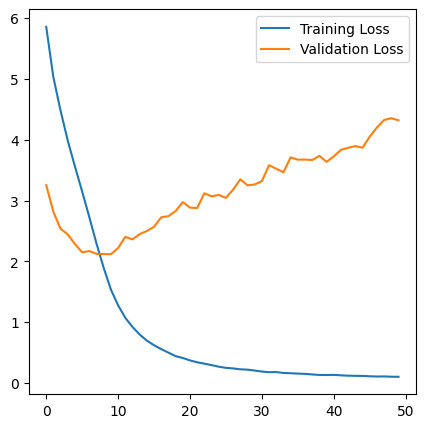

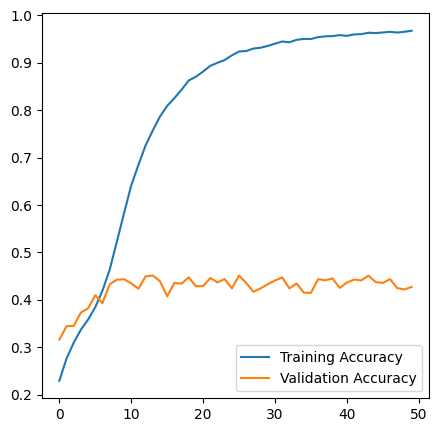

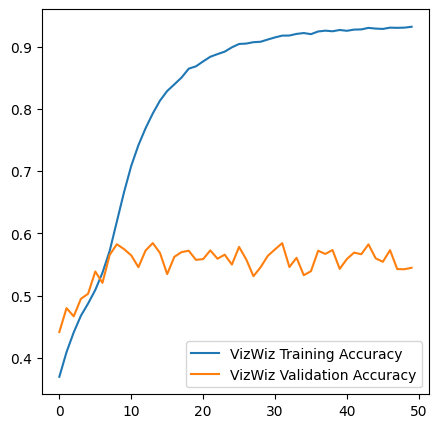

In [17]:
#train model
# Configuring training's hyperparameters
NUM_EPOCHS = 50
LR = 1e-4
WEIGHT_DECAY = 0
NUM_CLASSES = len(training_dataset.get_answer_vocab())
SAVE_PATH = OUTPUT_PATH + "CLIP_v9"
SAVE_EVERY = 50

# Initializing the model
model = VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
model.print_CLIP_model()

# Initializing the loss function and optimizer
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

# Training the model and plotting the loss and accuracy
model.train_model(training_dataloader, validation_dataloader, test_dataloader, loss_function, optimizer, epochs=NUM_EPOCHS, save_path=SAVE_PATH, save_every=SAVE_EVERY)
model.plot_loss()
model.plot_accuracy()
model.plot_vizwiz_accuracy()


# Training model on a new dataset

To further enhance the model’s performance, we retrained it on a larger and more diverse dataset. By training on a wider variety of inputs, the model’s ability to generalize improved significantly. As a result, the model achieved an accuracy of 41% on our benchmark, demonstrating a substantial improvement in its performance and robustness.

## Reconfigure the path

In [18]:
ANNOTATIONS_PATH = '/content/drive/MyDrive/9444/Dataset/merged_data.json'
IMG_DIR = '/content/drive/MyDrive/9444/Dataset/val2014'
OUTPUT_PATH = '/content/drive/MyDrive/9444/Training_output/'

In [21]:
def get_pkl_path(dataset_type, data_type):
  pkl_dir = OUTPUT_PATH + '/pklnew/'
  path = pkl_dir + f'Training_output{dataset_type}_{data_type}.pkl'
  return path

## Reload Data

In [31]:
train_df = read_dataframe(ANNOTATIONS_PATH)
# validation_df = read_dataframe(ANNOTATIONS_VAL_PATH) # TODO
train_df, valid_df, test_df = split_train_valid_test(train_df)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  72683


In [27]:
#load pkl
OUTPUT_PATH='/content/drive/MyDrive/9444/Training_output/'
with open(get_pkl_path('training', 'images'), 'rb') as f:
    training_images_new = pickle.load(f)
with open(get_pkl_path('training', 'questions'), 'rb') as f:
    training_questions_new = pickle.load(f)

with open(get_pkl_path('validation', 'images'), 'rb') as f:
    validation_images_new = pickle.load(f)
with open(get_pkl_path('validation', 'questions'), 'rb') as f:
    validation_questions_new = pickle.load(f)

with open(get_pkl_path('test', 'images'), 'rb') as f:
    test_images_new = pickle.load(f)
with open(get_pkl_path('test', 'questions'), 'rb') as f:
    test_questions_new = pickle.load(f)
print('load done')

load done


In [32]:
# Constructing the training dataset
training_dataset = VizWizDataset(train_df, None, None, MODEL_NAME, training_images_new, training_questions_new)
ANSWER_ONEHOTENCODER = training_dataset.answer_onehotencoder
ANSWER_TYPE_ONEHOTENCODER = training_dataset.answer_type_onehotencoder

# Saving the fitted one hot encoders
with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_ONEHOTENCODER, f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_TYPE_ONEHOTENCODER, f)

# Constructing the validation dataset
validation_dataset = VizWizDataset(validation_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, validation_images, validation_questions)

# Constructing the test dataset
test_dataset = VizWizDataset(test_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, test_images, test_questions)

# Configuring the data loaders
BATCH_SIZE = 32 # 64 is good too but 32 is better (variance wise)

# Constructing the training, validation and test data loaders
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Number of distinct answers:  11287
Number of distinct answers:  1531
Number of distinct answers:  3270


## Load the trained model and retrain the model on new dataset.

In [33]:
import math
NUM_CLASSES = 5410
MODEL_PATH = "/content/drive/MyDrive/9444clip/OUTPUT/epoch_50local.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "ViT-L/14@336px"

# Reinitialize the last layer
model.classification_head[3] = torch.nn.Linear(512, NUM_CLASSES).to(DEVICE)

# Initialize the VQAModel
model = VQAModel(num_classes=NUM_CLASSES, device=DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)

# Load model state
# model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
model.load_state_dict(torch.load(MODEL_PATH), strict=False)

print('Model loading complete')


<ipython-input-33-f2a9033fcf64>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH), strict=False)


Model loading complete


Selected model: ViT-L/14@336px
Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408

Epoch [1/50], Training Loss: 4.7810, Training Accuracy: 21.91%, Validation Loss: 13.3560, Validation Accuracy: 1.83%
Epoch [2/50], Training Loss: 4.4050, Training Accuracy: 23.34%, Validation Loss: 16.1458, Validation Accuracy: 1.92%
Epoch [3/50], Training Loss: 4.2609, Training Accuracy: 23.78%, Validation Loss: 15.4811, Validation Accuracy: 1.85%
Epoch [4/50], Training Loss: 4.1172, Training Accuracy: 24.09%, Validation Loss: 19.9134, Validation Accuracy: 1.97%
Epoch [5/50], Training Loss: 3.9856, Training Accuracy: 24.61%, Validation Loss: 17.4295, Validation Accuracy: 1.83%
Epoch [6/50], Training Loss: 3.8937, Training Accuracy: 24.81%, Validation Loss: 18.6549, Validation Accuracy: 1.90%
Epoch [7/50], Training Loss: 3.7944, Training Accuracy: 25.26%, Validation Loss: 17.2454, Validation Accuracy: 2.18%
Epoch [8/50], Training Loss: 3.7105, Training Accuracy: 25.8

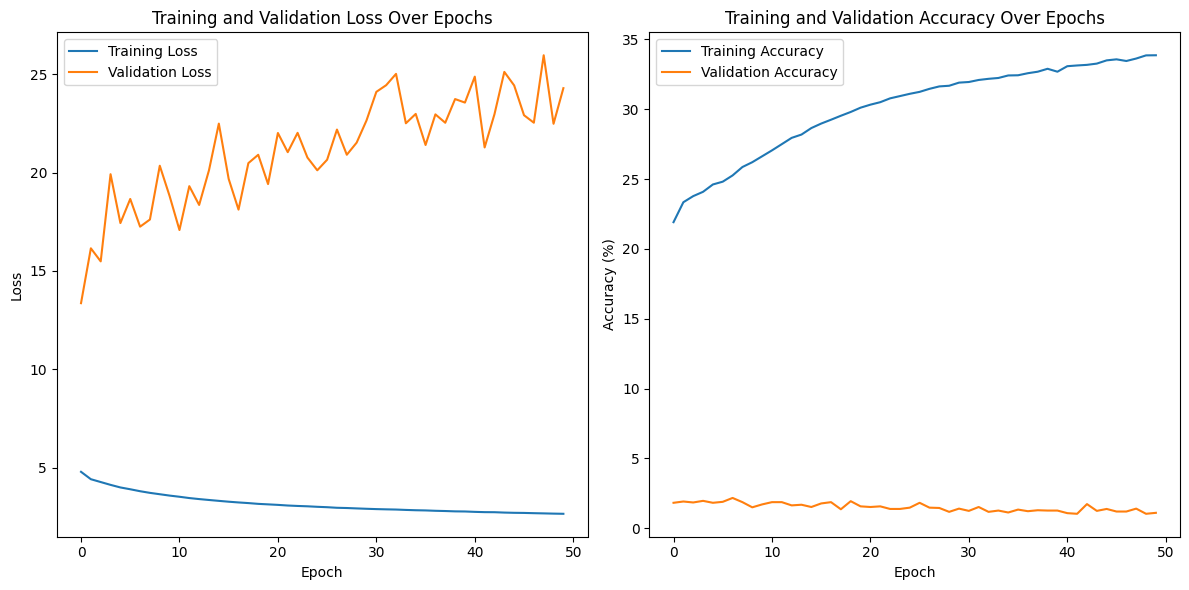

In [35]:
# Train the model
# Configuring training hyperparameters
NUM_EPOCHS = 50
LR = 5e-4
WEIGHT_DECAY = 0
NUM_CLASSES = len(training_dataset.get_answer_vocab())
SAVE_PATH = OUTPUT_PATH
SAVE_EVERY = 50
BATCH_SIZE = 32

# Save answer_vocab to a JSON file

# Retrieve answer_vocab and convert to list (if answer_vocab is of ndarray type)
answer_vocab = training_dataset.get_answer_vocab().tolist()

# Save answer_vocab to a JSON file
with open(SAVE_PATH + '/answer_vocab.json', 'w') as f:
    json.dump(answer_vocab, f)

# Initialize the model
model = VQAModel(num_classes=NUM_CLASSES, device=DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
model.print_CLIP_model()

# Initialize loss function and optimizer
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Configure dataloaders for training, validation, and testing
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Lists for recording training and validation losses
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Training the model
for epoch in range(NUM_EPOCHS):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch in training_dataloader:
        images, questions, one_hot_targets, answer_type_labels, additional_data, batch_constants = batch

        # Move data to the device
        images = images.to(DEVICE)
        questions = questions.to(DEVICE)
        one_hot_targets = one_hot_targets.to(DEVICE)

        # Convert one-hot encoded targets to class indices
        targets = torch.argmax(one_hot_targets, dim=1)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, questions)

        # If outputs is a tuple, use the first element as logits
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Compute the loss
        loss = loss_function(outputs, targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    # Calculate training loss and accuracy for each epoch
    epoch_train_loss = running_loss / len(training_dataloader)
    epoch_train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0
    training_losses.append(epoch_train_loss)
    training_accuracies.append(epoch_train_accuracy)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # Disable gradient computation during validation
        for batch in validation_dataloader:
            images, questions, one_hot_targets, _, _, _ = batch
            images = images.to(DEVICE)
            questions = questions.to(DEVICE)
            one_hot_targets = one_hot_targets.to(DEVICE)

            targets = torch.argmax(one_hot_targets, dim=1)

            outputs = model(images, questions)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = loss_function(outputs, targets)
            validation_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)

    # Calculate validation loss and accuracy for each epoch
    epoch_val_loss = validation_loss / len(validation_dataloader)
    epoch_val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0
    validation_losses.append(epoch_val_loss)
    validation_accuracies.append(epoch_val_accuracy)

    # Print loss and accuracy for each epoch
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%, "
          f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%")

    # Save the model every 'SAVE_EVERY' epochs
    if (epoch + 1) % SAVE_EVERY == 0:
        torch.save(model.state_dict(), SAVE_PATH + f'_epoch{epoch+1}.pth')

# Plot training and validation loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Over Epochs")

# Plot training and validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label="Training Accuracy")
plt.plot(validation_accuracies, label="Validation Accuracy")2
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training and Validation Accuracy Over Epochs")

plt.tight_layout()
plt.show()


# Generate the answer

In this section, we use our model to generate answers on two different datasets, each serving as a separate benchmark for evaluating the model’s performance.

## Generate the answer for VQA Benchmark

In [36]:
def generate_answers(questions_path, answers_path, processor, clip_model, trained_model, device, resume=False):
    # Load questions
    with open(questions_path) as file:
        questions_file = json.load(file)
    questions = questions_file['questions']

    # Load existing answers to resume if the script was interrupted, only if resume is True
    processed_ids = set()
    if resume and os.path.exists(answers_path):
        with open(answers_path, 'r') as file:
            for line in file:
                existing_answer = json.loads(line)
                processed_ids.add(existing_answer['question_id'])

    # Process questions and generate answers
    count = 0
    with open(answers_path, 'a') as file:
        for question in questions:
            question_id = question['question_id']

            # Skip already processed questions if resume is enabled
            if resume and question_id in processed_ids:
                continue

            image_id = question['image_id']
            image_path = os.path.join('/content/drive/MyDrive/9444/Dataset', 'val2014', f'COCO_val2014_{str(image_id).zfill(12)}.jpg')

            # Extract image and question features
            images_features = process_single_image(image_path, clip_model, preprocessor, DEVICE)
            images_features = images_features.unsqueeze(0)
            question_features = process_single_question(question['question'], clip_model, DEVICE)
            question_features = question_features.unsqueeze(0)

            # Directly call test_model function to predict the answer
            predicted_answer, predicted_answer_type, answerability = trained_model.test_model(
                image=images_features,
                question=question_features
            )

            # Decode predicted answer
            with open('/content/drive/MyDrive/9444/Training_output/pklnew/answer_onehotencoder.pkl', 'rb') as f:
                ANSWER_ONEHOTENCODER = pickle.load(f)

            answer_text = ANSWER_ONEHOTENCODER.inverse_transform(predicted_answer.cpu().detach().numpy())

            # Save the answer as a new line in the JSONL file
            answer_entry = {
                "answer": answer_text[0][0],
                "question_id": question_id,
            }
            file.write(json.dumps(answer_entry) + '\n')
            file.flush()  # Ensures data is written immediately to disk

            print(count, ':', question_id, 'done')
            count += 1


In [37]:
# Load the pre-trained model (assuming the model is saved as 'trained_model.pth')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "ViT-L/14@336px"
clip_model, preprocessor = clip.load(MODEL_NAME, device=DEVICE)
clip_model.eval().requires_grad_(False)

# NUM_CLASSES is set to 11287 (using the same vocabulary as during training)
NUM_CLASSES = 11287
MODEL_PATH = "/content/drive/MyDrive/9444/CLIP_checkpoints/_epoch50_2_data.pth"

# Reinitialize the last layer of the classification head
model.classification_head[3] = torch.nn.Linear(512, NUM_CLASSES).to(DEVICE)

# Load the weights (no error in strict mode)
model = VQAModel(num_classes=NUM_CLASSES, device=DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
# model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
model.load_state_dict(torch.load(MODEL_PATH), strict=False)

# Define the paths for questions and answers
Questions_path = os.path.join('/content/drive/MyDrive/9444/Dataset', 'clip_splitted_v2_OpenEnded_mscoco_val2014_questions.json')
Answers_path = os.path.join('/content/drive/MyDrive/9444/clip_answers', 'clip_answers_VQA_2.jsonl')


100%|███████████████████████████████████████| 891M/891M [00:13<00:00, 66.8MiB/s]
<ipython-input-37-6db50ebdec81>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load

In [ ]:
with open(Answers_path, 'w') as f:
    pass  # This creates an empty file
os.path.exists(Answers_path)

In [ ]:
from sklearn.model_selection import train_test_split

questions_path = os.path.join('/content/drive/MyDrive/9444/Dataset', 'v2_OpenEnded_mscoco_val2014_questions.json')
with open(questions_path, 'r') as file:
    questions_file = json.load(file)
    questions = questions_file['questions']

splitted_path = os.path.join('/content/drive/MyDrive/9444/Dataset', 'clip_splitted_v2_OpenEnded_mscoco_val2014_questions.json')
train_questions, test_questions = train_test_split(questions, test_size=0.90, random_state=42)
print(len(train_questions))
with open(splitted_path, 'w') as file:
  questions_file['questions'] = train_questions
  json.dump(questions_file, file)

In [ ]:
generate_answers(
    questions_path=Questions_path,
    answers_path=Answers_path,
    processor=preprocessor,
    clip_model=clip_model,
    trained_model=model,
    device=DEVICE,
    resume=False
)

## Generate answer for GQA Benchmark

# Demo

In [ ]:
# Load the JSON data
print('start load')
with open("/content/drive/MyDrive/9444clip/comp9444/Annotations/Annotations/test.json", "r") as file:
    data = json.load(file)
print('load done!')

In [ ]:
def complete_image_filename(image_id):
    padded_id = str(image_id).zfill(8)
    filename = f"VizWiz_test_{padded_id}.jpg"
    return filename

In [ ]:
import json
import random
import torch
import pickle
import matplotlib.pyplot as plt
from PIL import Image

# Load One Hot Encoders
with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'rb') as f:
    ANSWER_ONEHOTENCODER = pickle.load(f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'rb') as f:
    ANSWER_TYPE_ONEHOTENCODER = pickle.load(f)

# Load the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "ViT-L/14@336px"
NUM_CLASSES = len(training_dataset.get_answer_vocab())  # Using the same vocabulary as during training
MODEL_PATH = OUTPUT_PATH + "epoch_50local.pth"
model = VQAModel(num_classes=NUM_CLASSES, device=DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))

# Load JSON file
with open("/content/drive/MyDrive/9444clip/comp9444/Annotations/Annotations/test.json", 'r') as f:
    test_data = json.load(f)


In [ ]:
# Find the question by image ID and predict the answer
def predict_by_image_id(image_id):
    # Find the corresponding sample
    sample = next((item for item in test_data if item["image"] == image_id), None)

    if sample is None:
        print(f"Image ID {image_id} not found in the JSON file.")
        return

    # Retrieve the question and image path
    question = sample["question"]
    image_path = "/content/drive/MyDrive/9444clip/comp9444/test/test/" + image_id

    # Predict the answer and answer type
    predicted_answer, predicted_answer_type, answerability = model.test_model(image_path=image_path, question=question)
    answer = ANSWER_ONEHOTENCODER.inverse_transform(predicted_answer.cpu().detach().numpy())
    # answer_type = ANSWER_TYPE_ONEHOTENCODER.inverse_transform(predicted_answer_type.cpu().detach().numpy())
    # answer = ANSWER_ONEHOTENCODER.inverse_transform([[predicted_answer]])
    # answer_type = ANSWER_TYPE_ONEHOTENCODER.inverse_transform([[predicted_answer_type]])

    # Display the image and output the results
    plt.imshow(Image.open(image_path))
    plt.axis('off')
    plt.show()
    print('The image ID is: ' + image_id)
    print("The Question is: " + question)
    print("The Answer is: " + answer[0][0])
    # print("The Answer Type is: " + answer_type[0][0])
    # print("The confidence for being unanswerable: " + str(answerability.item()))
    print("-" * 40)
